In [1]:
import tensorflow as tf
# tf.logging.set_verbosity(tf.logging.ERROR)

import numpy as np
import keras
from PIL import Image
# from IPython.display import display, HTML
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,Dropout, Flatten, Dense
from keras import regularizers
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder # one-hot encoding for age
from keras.utils.np_utils import to_categorical


import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2
import os

In [2]:
import glob

In [3]:
df = pd.read_csv('train.csv')
df.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


In [4]:
df['Id'] = df['Id'] + '.jpg';
df['Id']

0       0007de18844b0dbbb5e1f607da0606e0.jpg
1       0009c66b9439883ba2750fb825e1d7db.jpg
2       0013fd999caf9a3efe1352ca1b0d937e.jpg
3       0018df346ac9c1d8413cfcc888ca8246.jpg
4       001dc955e10590d3ca4673f034feeef2.jpg
                        ...                 
9907    ffbfa0383c34dc513c95560d6e1fdb57.jpg
9908    ffcc8532d76436fc79e50eb2e5238e45.jpg
9909    ffdf2e8673a1da6fb80342fa3b119a20.jpg
9910    fff19e2ce11718548fa1c5d039a5192a.jpg
9911    fff8e47c766799c9e12f3cb3d66ad228.jpg
Name: Id, Length: 9912, dtype: object

In [5]:
df.drop([ 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis = 1,inplace = True)

In [6]:
df

,Id,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0.jpg,63
1,0009c66b9439883ba2750fb825e1d7db.jpg,42
2,0013fd999caf9a3efe1352ca1b0d937e.jpg,28
3,0018df346ac9c1d8413cfcc888ca8246.jpg,15
4,001dc955e10590d3ca4673f034feeef2.jpg,72
...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57.jpg,15
9908,ffcc8532d76436fc79e50eb2e5238e45.jpg,70
9909,ffdf2e8673a1da6fb80342fa3b119a20.jpg,20
9910,fff19e2ce11718548fa1c5d039a5192a.jpg,20


In [7]:
df.Id[0]

'0007de18844b0dbbb5e1f607da0606e0.jpg'

In [8]:
X = []
Y = []
width = 100
height = 100

for index, row in df.iterrows():
    file_path = "train" +"/"+ row.Id
    image = Image.open(file_path)
    image = image.convert('RGB')
    image = image.resize((width, height))
    X.append(np.array(image))
    Y.append(row.Pawpularity)

In [13]:
# Normalise input data to range [0,1]
X = np.array(X)
X = X.astype('float32')
X /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))

Y = np.array(Y)

Min: 0.000, Max: 1.000


In [14]:

test_size = 0.3
seed = 42
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=test_size, 
                                                    random_state=seed,
                                                    shuffle=True,
                                                    stratify=Y)

X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size=0.5)




In [15]:

# Apply Image Augmentation

train_datagen = ImageDataGenerator(
    shear_range = 0.2, # random application of shearing
    zoom_range = 0.2,
    horizontal_flip = True) # randomly flipping half of the images horizontally

test_datagen = ImageDataGenerator(
)

In [16]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=5, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't inrease (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=3, # if val_loss plateaus for 3 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

        
# hyperparameters
lr = 0.01
epochs = 30 # setting it to a low number since this is for Kaggle, ideally you should set this to a higher number ~ 100 so that the model overfits training data, and then apply the elbow methods to select the best params on validaion data
batch_size = 128
results = {}
input_shape =[width,height]
num_of_ages = 100

In [17]:
def baseline_model():
    model = Sequential()
    model.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu",
                   padding="valid",
                   kernel_regularizer=regularizers.l2(0.00001),
                   input_shape=(input_shape[0], input_shape[1], 3)))
    model.add(MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1,activation="linear")) 
    return model

In [18]:
Adam= keras.optimizers.Adam(lr=0.1,beta_1=0.9, beta_2=0.999, decay=0.0)

In [19]:
model = baseline_model()

model.compile(optimizer="adam",loss="mean_absolute_error",metrics=['mean_absolute_error'])

model_history = model.fit_generator(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), # use augmented images
            validation_data = (X_val,Y_val),
            steps_per_epoch=X_train.shape[0] // batch_size,
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
54/54 [==============================] - 42s 778ms/step - loss: 17.6375 - mean_absolute_error: 17.6374 - val_loss: 15.4504 - val_mean_absolute_error: 15.4504
Epoch 2/30
54/54 [==============================] - 48s 884ms/step - loss: 15.6170 - mean_absolute_error: 15.6169 - val_loss: 14.8002 - val_mean_absolute_error: 14.8002
Epoch 3/30
54/54 [==============================] - 44s 808ms/step - loss: 15.1281 - mean_absolute_error: 15.1281 - val_loss: 14.7976 - val_mean_absolute_error: 14.7975
Epoch 4/30
54/54 [==============================] - 52s 964ms/step - loss: 15.0873 - mean_absolute_error: 15.0872 - val_loss: 14.7643 - val_mean_absolute_error: 14.7642
Epoch 5/30
54/54 [==============================] - 44s 811ms/step - loss: 15.0680 - mean_absolute_error: 15.0680 - val_loss: 15.0796 - val_mean_absolute_error: 15.0796
Epoch 6/30
54/54 [==============================] - 39s 728ms/step - loss: 14.9

In [20]:
baseline_adam_train_loss = model_history.history["loss"]
baseline_adam_val_loss = model_history.history["val_loss"]
baseline_adam_train_acc = model_history.history["mean_absolute_error"]
baseline_adam_val_acc = model_history.history["val_mean_absolute_error"]


results["baseline_adam"] = {'train-loss': baseline_adam_train_loss,
                             'val-loss': baseline_adam_val_loss,
                             'train-mae': baseline_adam_train_acc,
                             'val-mae': baseline_adam_val_acc}

In [21]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
base_mobilenet_model = MobileNet(input_shape =  (input_shape[0],input_shape[1], 3), 
                                 include_top = False, 
                                 weights = None)
mobilenet_model = Sequential()
mobilenet_model.add(BatchNormalization(input_shape = (input_shape[0],input_shape[1], 3)))
mobilenet_model.add(base_mobilenet_model)
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(1,activation='linear')) 



mobilenet_model.compile(optimizer = 'adam', loss = 'mean_absolute_error',
                           metrics = ["mean_absolute_error"])

# mobilenet_model.summary()

# Fit model on training data
mobilenet_model_history = mobilenet_model.fit_generator(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), 
            validation_data = (X_val,Y_val),
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)

Epoch 1/30
55/55 [==============================] - 371s 7s/step - loss: 36.6635 - mean_absolute_error: 36.6635 - val_loss: 34.1185 - val_mean_absolute_error: 34.1185
Epoch 2/30
55/55 [==============================] - 345s 6s/step - loss: 29.7129 - mean_absolute_error: 29.7129 - val_loss: 23.4895 - val_mean_absolute_error: 23.4895
Epoch 3/30
55/55 [==============================] - 351s 6s/step - loss: 17.9497 - mean_absolute_error: 17.9497 - val_loss: 14.5825 - val_mean_absolute_error: 14.5825
Epoch 4/30
55/55 [==============================] - 344s 6s/step - loss: 15.2241 - mean_absolute_error: 15.2241 - val_loss: 14.5287 - val_mean_absolute_error: 14.5287
Epoch 5/30
55/55 [==============================] - 344s 6s/step - loss: 14.9838 - mean_absolute_error: 14.9838 - val_loss: 14.5333 - val_mean_absolute_error: 14.5333
Epoch 6/30
55/55 [==============================] - 340s 6s/step - loss: 14.9333 - mean_absolute_error: 14.9333 - val_loss: 14.5537 - val_mean_absolute_error: 14.553

In [22]:
# Baseline model

model_test_results = model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(model.metrics_names, model_test_results)))

12/12 [==============================] - 2s 144ms/step - loss: 15.1552 - mean_absolute_error: 15.1551
{'loss': 15.155174255371094, 'mean_absolute_error': 15.155120849609375}


In [23]:
# MobileNet

mobilenet_model_test_results = mobilenet_model.evaluate(X_test, Y_test, batch_size=128)
print(dict(zip(mobilenet_model.metrics_names, mobilenet_model_test_results)))

12/12 [==============================] - 7s 557ms/step - loss: 15.1101 - mean_absolute_error: 15.1101
{'loss': 15.11011028289795, 'mean_absolute_error': 15.11011028289795}


In [24]:
df_test = pd.read_csv("test.csv")
Id = df_test["Id"].copy()

In [25]:
df_test["Id"] = df_test["Id"].apply(lambda x : x + ".jpg")

In [26]:
df_test

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur
0,4128bae22183829d2b5fea10effdb0c3.jpg,1,0,1,0,0,1,1,0,0,1,0,1
1,43a2262d7738e3d420d453815151079e.jpg,0,1,0,0,0,0,1,1,0,0,0,0
2,4e429cead1848a298432a0acad014c9d.jpg,0,0,0,1,0,1,1,1,0,1,1,1
3,80bc3ccafcc51b66303c2c263aa38486.jpg,1,0,1,0,0,0,0,0,0,0,1,0
4,8f49844c382931444e68dffbe20228f4.jpg,1,1,1,0,1,1,0,1,0,1,1,0
5,b03f7041962238a7c9d6537e22f9b017.jpg,0,0,1,1,1,1,1,1,1,0,1,0
6,c978013571258ed6d4637f6e8cc9d6a3.jpg,1,0,0,0,1,1,0,1,0,1,1,1
7,e0de453c1bffc20c22b072b34b54e50f.jpg,1,0,1,0,0,0,0,0,1,0,0,1


In [27]:
X = []
Y = []
width = 100
height = 100

for index, row in df_test.iterrows():
    file_path = "test" +"/"+ row.Id
    image = Image.open(file_path)
    image = image.convert('RGB')
    image = image.resize((width, height))
    X.append(np.array(image))
#     Y.append(row.Pawpularity)

In [33]:
# X

In [29]:
# Normalise input data to range [0,1]
X = np.array(X)
X = X.astype('float32')
X /= 255.0
# confirm the normalization
print('Min: %.3f, Max: %.3f' % (X.min(), X.max()))

# Y = np.array(Y)

Min: 0.000, Max: 1.000


In [30]:
predicted_ages = model.predict(X)

In [31]:
predicted_ages

array([[42.772358],
       [42.74786 ],
       [42.90917 ],
       [43.00191 ],
       [42.76608 ],
       [43.037506],
       [42.882668],
       [43.17278 ]], dtype=float32)

In [32]:
pred_mobile_pop= mobilenet_model.predict(X)
pred_mobile_pop

array([[33.65443 ],
       [33.65647 ],
       [33.65442 ],
       [33.64621 ],
       [33.655827],
       [33.646152],
       [33.643513],
       [33.64892 ]], dtype=float32)

## Model 3: VGG16

In [34]:
from keras.applications import VGG16


conv_base = VGG16(weights='imagenet',                
                  include_top=False,              
                  input_shape=(input_shape[0],input_shape[1], 3))

for layer in conv_base.layers: # make VGG16 weights untrainable
    layer.trainable = False

58892288/58889256 [==============================] - 15s 0us/step


In [35]:
import keras

vgg_adam = Sequential() 
vgg_adam.add(conv_base) 
vgg_adam.add(MaxPooling2D())
vgg_adam.add(Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(0.00001)))
vgg_adam.add(Dropout(0.5))
vgg_adam.add(Flatten())
vgg_adam.add(Dense(1,activation="linear"))

vgg_adam.compile(optimizer = "adam",loss="mean_absolute_error", metrics=["mean_absolute_error"])

In [36]:
vgg_adam_history = vgg_adam.fit_generator(
            train_datagen.flow(X_train,Y_train,
                         batch_size = batch_size), # use augmented images
            validation_data = (X_val,Y_val),
            steps_per_epoch=X_train.shape[0] // batch_size,
            epochs = epochs,
            callbacks = [
                         reduce_learning_rate,
                         early_stopping,
                         time_callback
                        ],
            verbose=True)

Epoch 1/30
54/54 [==============================] - 428s 8s/step - loss: 17.3113 - mean_absolute_error: 17.3046 - val_loss: 14.7592 - val_mean_absolute_error: 14.7526
Epoch 2/30
54/54 [==============================] - 406s 8s/step - loss: 15.0072 - mean_absolute_error: 15.0008 - val_loss: 14.4990 - val_mean_absolute_error: 14.4926
Epoch 3/30
54/54 [==============================] - 418s 8s/step - loss: 14.8515 - mean_absolute_error: 14.8451 - val_loss: 14.5219 - val_mean_absolute_error: 14.5155
Epoch 4/30
54/54 [==============================] - 410s 8s/step - loss: 14.8351 - mean_absolute_error: 14.8286 - val_loss: 14.7424 - val_mean_absolute_error: 14.7359
Epoch 5/30
54/54 [==============================] - 438s 8s/step - loss: 14.7804 - mean_absolute_error: 14.7739 - val_loss: 14.3516 - val_mean_absolute_error: 14.3451
Epoch 6/30
54/54 [==============================] - 430s 8s/step - loss: 14.7499 - mean_absolute_error: 14.7433 - val_loss: 14.3542 - val_mean_absolute_error: 14.347

In [37]:
vgg_adam_train_loss = vgg_adam_history.history["loss"]
vgg_adam_val_loss = vgg_adam_history.history["val_loss"]
vgg_adam_train_acc = vgg_adam_history.history["mean_absolute_error"]
vgg_adam_val_acc = vgg_adam_history.history["val_mean_absolute_error"]


results["vgg_adam"] = {'train-loss': vgg_adam_train_loss,
                             'val-loss': vgg_adam_val_loss,
                             'train-mae': vgg_adam_train_acc,
                             'val-mae': vgg_adam_val_acc}

In [39]:
mobilenet_train_loss = mobilenet_model_history.history["loss"]
mobilenet_val_loss = mobilenet_model_history.history["val_loss"]
mobilenet_train_acc = mobilenet_model_history.history["mean_absolute_error"]
mobilenet_val_acc = mobilenet_model_history.history["val_mean_absolute_error"]


results["mobilenet_adam"] = {'train-loss': mobilenet_train_loss,
                             'val-loss': mobilenet_val_loss,
                             'train-mae': mobilenet_train_acc,
                             'val-mae': mobilenet_val_acc}

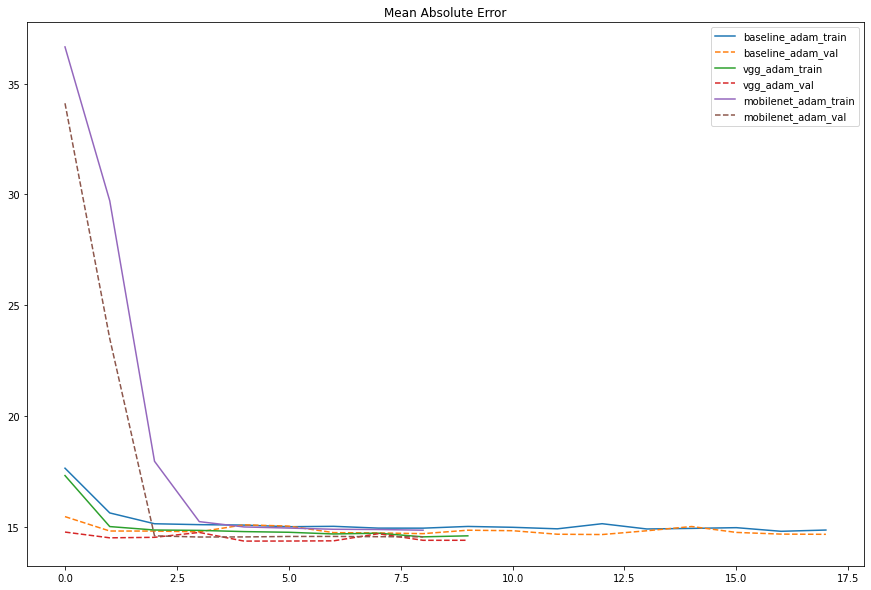

In [43]:
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(15,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-mae'])),results[cond]['train-mae'], '-', label=cond+"_train")
    plt.plot(range(len(results[cond]['val-mae'])),results[cond]['val-mae'], '--', label=cond+"_val")
plt.title("Mean Absolute Error")
plt.legend()
plt.show()

In [44]:
pred__vgg= vgg_adam.predict(X)
pred__vgg

array([[30.544806],
       [29.323105],
       [27.641794],
       [28.651056],
       [29.364468],
       [26.702648],
       [28.260298],
       [29.203066]], dtype=float32)